In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [2]:
T = 0.005
s = ctl.TransferFunction.s

In [3]:
G = 0.00651533410784146*(1.0*s - 0.709449128)/(0.284150193*s - 1.0)
C = (-7.70806287657038*s**2 + 103.036398760451*s + 52.693310762696)/(s**2 + 10*s)

G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([-0.0502206 ,  0.70694553, -0.13295043, -0.24356419]), array([  0.23392959,   2.54844746, -10.13295043,  -0.24356419]))

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [4]:
G_z = ctl.c2d(G, T, method='zoh')
G_z

TransferFunction(array([ 0.02292919, -0.02301125]), array([ 1.        , -1.01775206]), 0.005)

In [5]:
C_z = ctl.c2d(C, T, method='tustin')
C_z

TransferFunction(array([-7.26843175, 15.04076529, -7.77104833]), array([ 1.        , -1.95121951,  0.95121951]), 0.005)

In [6]:
G_z_feedback = ctl.feedback(G_z*C_z, 1)
G_z_feedback

TransferFunction(array([-0.16665926,  0.51212826, -0.52429061,  0.17882151]), array([ 0.83334074, -2.45684331,  2.41278657, -0.7892841 ]), 0.005)

c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]


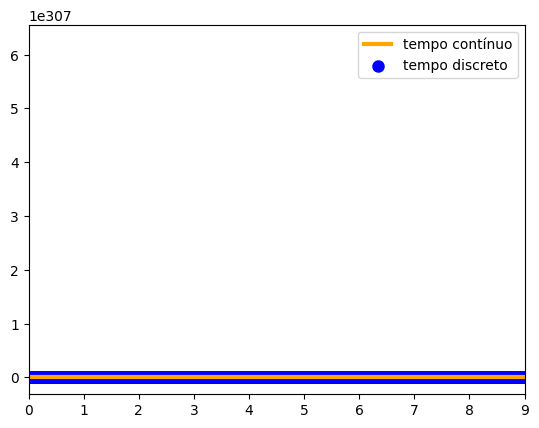

In [7]:
time, response = ctl.step_response(G_feedback)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

time, response = ctl.step_response(G_z_feedback)
plt.scatter(time, response, color='blue', linewidth=3, label='tempo discreto')

plt.xlim([0, 9])
plt.legend()
plt.show()

# COMPARANDO A RESPOSTA DO CONTROLADOR

- Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada

In [8]:
num, den = ctl.tfdata(C_z)
num = np.squeeze(num)
den = np.squeeze(den)

num = num/den[0]
den = den/den[0]

print(num)
print(den)

[-7.26843175 15.04076529 -7.77104833]
[ 1.         -1.95121951  0.95121951]


- Printando a saída de forma a ser entendida por uma máquina de baixo nível

In [9]:
out = ''

for i in range(0, len(num)):
    out += f'{num[i]}*X_n{i} + '

for i in range(1, len(den)):
    out += f'+ {-1*den[i]}*Y_n{i}'

out = out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')
print(out + ';')

-7.268431752660472*X_n + 15.040765287341745*X_n1 -7.771048331979746*X_n2 + 1.951219512195122*Y_n1-0.951219512195122*Y_n2;


- Resposta do controlador em feedback

In [10]:
Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

def computeController(inputValue, setpoint):
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3

    X_n = setpoint - inputValue
    Y_n = eval(out)

    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n

- Comparando os dados contínuo e digital de forma gráfica através de um step

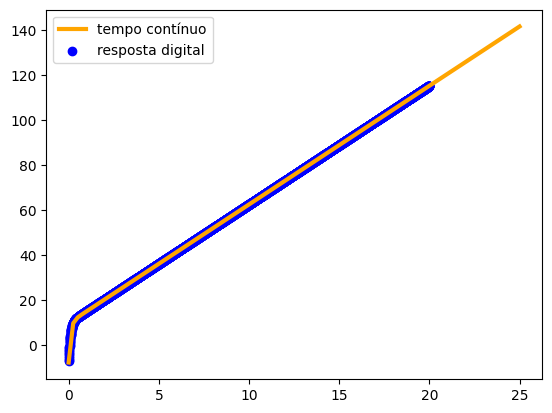

In [11]:
time, response = ctl.step_response(C)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 20, T)
response = [computeController(1, 2) for i in time] # degrau (erro 1 é a entrada)
plt.scatter(time, response, color='blue', label='resposta digital')

plt.legend()
plt.show()

# TESTANDO A RESPOSTA
- Se o erro é positivo, o controlador atua aumentando a saída do sistema

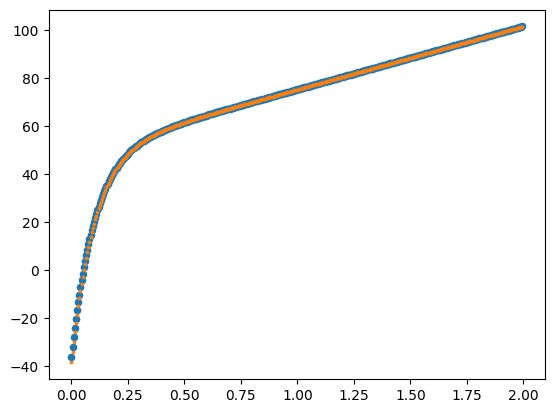

In [12]:
inputValue = 5
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response, s=20)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)

- Se o erro é negativo, o controlador atua diminuindo a saída do sistema

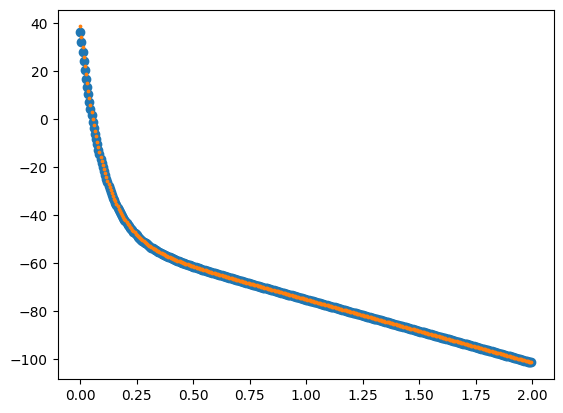

In [13]:
inputValue = 15
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)

- Se o erro é zero, o não atua e mantém a saída fixa

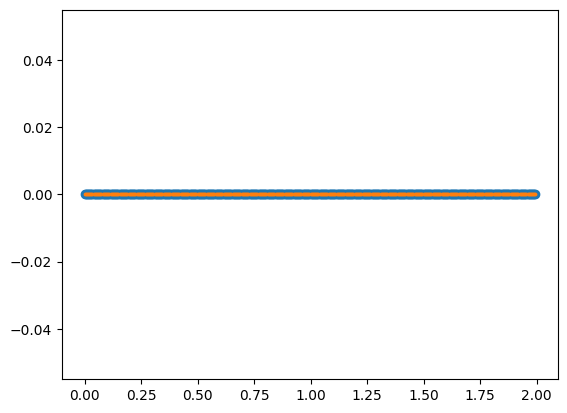

In [14]:
inputValue = 10
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)